In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy as dc
from torch.utils.data import Dataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import random
import datetime
# from torch.optim import Adam,AdamW
# from torch.optim import RMSprop

Dataset Load

In [2]:
#Path to Toronto Data
toronto_path = ["../dataset/toronto-occupancy*.csv", 
                "../dataset/toronto-weather*.csv", 
                "../dataset/toronto-inflation*.csv", 
                "../dataset/toronto-unemployment*.csv",
                "../dataset/toronto-cpi*.csv"]

calgary_path = ["../dataset/calgary-occupancy*.csv", 
                "../dataset/calgary-weather*.csv", 
                "../dataset/calgary-inflation*.csv", 
                "../dataset/calgary-unemployment*.csv",
                "../dataset/calgary-cpi*.csv"]


In [5]:
def load_csv_to_pandas(file_path):
    try:
        # Load CSV file into a pandas data_23Frame
        df = pd.read_csv(file_path, header=0, low_memory=False, encoding='unicode_escape')
        print("Number of rows in the dataFrame:", file_path, len(df))
        return df
    except FileNotFoundError:
        print(f"File '{file_path}' not found.")
        return None
    except Exception as e:
        print("An error occurred:", str(e))
        return None

def clean_and_standardize_date(date_str):
    try:
        # Case 1: Format like 22-01-01 (YY-MM-DD)
        if len(date_str) == 8 and '-' in date_str:
            return datetime.strptime(date_str, "%y-%m-%d").date()
        # if len(date_str) == 6 and '-' in date_str:
        #     return datetime.strptime(date_str, "%y-%m").date()
        # Case 2: ISO format with time or standard YYYY-MM-DD
        return pd.to_datetime(date_str).date()
    
    except Exception:
        return pd.NaT 

In [3]:
import glob

def loadData(city):

    city_paths = {
    "calgary": calgary_path,
    "toronto": toronto_path,
    }
    path = city_paths[city]

    output_data = glob.glob(path[0])
    weather_data = glob.glob(path[1])
    inflation = glob.glob(path[2])[0]
    unemployment = glob.glob(path[3])[0]
    cpi = glob.glob(path[4])[0]

    #-------Output Data-------#
    #Loading up the links to the output dataset
    for i in range(len(output_data)):
        output_data[i] = load_csv_to_pandas(output_data[i])

    #Dropping irrelevant columns for output datasets
    for i in range(len(output_data)):
        #print(output_data[i])
        output_data[i] = output_data[i].drop(columns = ['_id', 'SHELTER_ID', 'LOCATION_ID', 'LOCATION_CITY', 'LOCATION_PROVINCE', 'PROGRAM_NAME', 'PROGRAM_AREA', 'SERVICE_USER_COUNT', 'CAPACITY_FUNDING_BED', 'UNOCCUPIED_BEDS', 'UNAVAILABLE_BEDS', 'CAPACITY_FUNDING_ROOM', 'UNOCCUPIED_ROOMS', 'UNAVAILABLE_ROOMS'])
        output_data[i]['OCCUPANCY_DATE'] = output_data[i]['OCCUPANCY_DATE'].astype(str).apply(clean_and_standardize_date)
        output_data[i]['OCCUPANCY_DATE'] =  pd.to_datetime(output_data[i]['OCCUPANCY_DATE'], format='%Y-%m-%d')

    #Joining the Output data together
    big_data = output_data[0]
    for i in range(1,len(output_data)):
        big_data = pd.concat([big_data, output_data[i]], ignore_index = True)

    #Determine the max and min date in the dataset to create a date vector to fill out empty values
    max_date = big_data['OCCUPANCY_DATE'].max()
    min_date = big_data['OCCUPANCY_DATE'].min()
    date_range = pd.date_range(start=min_date, end=max_date, freq = 'D')
    date_df = pd.DataFrame({'OCCUPANCY_DATE': date_range})

    print(big_data)
    #-------Weather Data-------#

    #loading up the links to the weather dataset
    for i in range(len(weather_data)):
        weather_data[i] = load_csv_to_pandas(weather_data[i])

    #Dropping irrelevant columns for weather datasets
    for i in range(len(weather_data)):
        weather_data[i] = weather_data[i].drop(columns = ['ï»¿"Longitude (x)"', 'Latitude (y)', 'Station Name', 'Climate ID', 'Year', 'Month', 'Day', 'Data Quality', 'Max Temp Flag', 'Min Temp Flag', 'Mean Temp Flag', 'Heat Deg Days Flag', 'Cool Deg Days Flag', 'Total Rain (mm)', 'Total Rain Flag', 'Total Snow (cm)', 'Total Snow Flag', 'Total Precip Flag',
        'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)', 'Dir of Max Gust Flag', 'Spd of Max Gust (km/h)', 'Spd of Max Gust Flag'])
        weather_data[i]['Date/Time'] = weather_data[i]['Date/Time'].astype(str)
        weather_data[i]['Date/Time'] = pd.to_datetime(weather_data[i]['Date/Time'])

    #Joining the Weather data together
    big_weather = weather_data[0]
    for i in range(1, len(weather_data)):
        big_weather = pd.concat([big_weather, weather_data[i]], ignore_index = True)

    #Cut down all data with dates that is bigger than the biggest date and smaller than the smallest date with an output
    big_weather = big_weather[big_weather['Date/Time'] <= max_date]
    big_weather = big_weather[big_weather['Date/Time'] >= min_date]

    #Fill out datasets' entries w no data w 0
    big_weather = big_weather.fillna(0)

    #Changing non output dataset's date column to 'OCCUPANCY_DATE'
    big_weather = big_weather.rename(columns = {'Date/Time': 'OCCUPANCY_DATE'})
    print(big_weather)
    #-------Inflation Data-------#

    #loading up housing data
    inflation = load_csv_to_pandas(inflation)

    #Dropping irrelevant columns for housing dataset
    inflation = inflation.rename(columns = {inflation.columns[0]: 'OCCUPANCY_DATE'})
    inflation = inflation.rename(columns = {inflation.columns[1]: 'INFLATION_RATE_CHANGE'})

    date_df['OCCUPANCY_DATE'] = pd.to_datetime(date_df['OCCUPANCY_DATE'])
    date_df['YEAR_MONTH'] = date_df['OCCUPANCY_DATE'].dt.to_period('M')


    if city == "calgary":
        inflation['OCCUPANCY_DATE'] = pd.to_datetime(inflation['OCCUPANCY_DATE'], format="%y-%b", errors='coerce')

        # Prepare unemployment data (monthly values)
        inflation['OCCUPANCY_DATE'] = pd.to_datetime(inflation['OCCUPANCY_DATE'])
        inflation['YEAR_MONTH'] = inflation['OCCUPANCY_DATE'].dt.to_period('M')

        inflation = inflation[
            (inflation['OCCUPANCY_DATE'] >= pd.to_datetime(min_date)) &
            (inflation['OCCUPANCY_DATE'] <= pd.to_datetime(max_date))
        ]

        # Merge on the unified OCCUPANCY_DATE column
        inflation = pd.merge(date_df, inflation.drop(columns='OCCUPANCY_DATE'), on='YEAR_MONTH', how='left')
        

    else:
        inflation["OCCUPANCY_DATE"] = pd.to_datetime(inflation["OCCUPANCY_DATE"])
        inflation = inflation[inflation["OCCUPANCY_DATE"] <= max_date].reset_index(drop=True)
        inflation = pd.merge(inflation, date_df, on = 'OCCUPANCY_DATE', how = 'outer')
        inflation = inflation.sort_values(by='OCCUPANCY_DATE').reset_index(drop=True)
        inflation = inflation.ffill()

    inflation = inflation.drop(columns='YEAR_MONTH')

    #-------Unemployment Data-------#
    
    #Loading the unemployment dataset
    unemployment = load_csv_to_pandas(unemployment)
    
    #Analyize Data
    unemployment = unemployment.rename(columns = {unemployment.columns[0]:'OCCUPANCY_DATE'})

    
    if city == "calgary":
        unemployment = unemployment.rename(columns = {unemployment.columns[1]:'UNEMPLOYMENT_RATE'})
    else:
        unemployment = unemployment.drop(columns = ['Labour force 7', 'Employment 8', 'Unemployment 9', 'Population 6', 
                                                'Participation rate 11', 'Employment rate 12'])
        unemployment = unemployment.rename(columns = {unemployment.columns[1]:'UNEMPLOYMENT_RATE'})

    #     unemployment = unemployment.rename(columns = {"Population 6": 'Population'})
    #     unemployment['Population'] = unemployment['Population'].str.replace(',', '', regex=False).astype(float)*1000
    #     unemployment = unemployment.rename(columns = {"Unemployment rate 10": 'UNEMPLOYMENT_RATE'})
    #     unemployment = unemployment.rename(columns = {"Participation rate 11": 'Employment_Participation_Rate'})
    #     unemployment = unemployment.rename(columns = {"Employment rate 12": 'Employment_Rate'})

    # Convert both date columns to datetime objects representing first day of month
    unemployment['OCCUPANCY_DATE'] = pd.to_datetime(unemployment['OCCUPANCY_DATE'], format="%y-%b", errors='coerce')
    # date_df['OCCUPANCY_DATE'] = pd.to_datetime(date_df['OCCUPANCY_DATE'])
    # date_df['YEAR_MONTH'] = date_df['OCCUPANCY_DATE'].dt.to_period('M')

    # Prepare unemployment data (monthly values)
    unemployment['OCCUPANCY_DATE'] = pd.to_datetime(unemployment['OCCUPANCY_DATE'])
    unemployment['YEAR_MONTH'] = unemployment['OCCUPANCY_DATE'].dt.to_period('M')

    unemployment = unemployment[
        (unemployment['OCCUPANCY_DATE'] >= pd.to_datetime(min_date)) &
        (unemployment['OCCUPANCY_DATE'] <= pd.to_datetime(max_date))
    ]

    # Merge on the unified OCCUPANCY_DATE column
    unemployment = pd.merge(date_df, unemployment.drop(columns='OCCUPANCY_DATE'), on='YEAR_MONTH', how='left')
    unemployment = unemployment.drop(columns='YEAR_MONTH')

    # unemployment.to_csv("unemply.csv")

    #-------CPI Data-------#
    
    # Load the CPI data
    cpi = load_csv_to_pandas(cpi)

    # Keep only necessary columns
    columns_to_keep = ['ï»¿"REF_DATE"', 'Products and product groups', 'VALUE']
    cpi = cpi[columns_to_keep]

    # Rename for clarity
    cpi = cpi.rename(columns={
        'ï»¿"REF_DATE"': 'OCCUPANCY_DATE',
        'Products and product groups': 'CPI_TYPE',
        'VALUE': 'CPI_VALUE'
    })

    cpi = cpi[cpi['CPI_TYPE'] == 'All-items'].reset_index(drop=True)
    cpi = cpi.drop(columns = ["CPI_TYPE"])

    # Convert to datetime (first day of month)
    cpi['OCCUPANCY_DATE'] = pd.to_datetime(cpi['OCCUPANCY_DATE'])

    # Convert date_df to proper datetime and generate YEAR_MONTH
    date_df['OCCUPANCY_DATE'] = pd.to_datetime(date_df['OCCUPANCY_DATE'])
    date_df['YEAR_MONTH'] = date_df['OCCUPANCY_DATE'].dt.to_period('M')

    cpi['YEAR_MONTH'] = cpi['OCCUPANCY_DATE'].dt.to_period('M')

    # Filter CPI based on min/max date
    cpi = cpi[
        (cpi['OCCUPANCY_DATE'] >= pd.to_datetime(min_date)) &
        (cpi['OCCUPANCY_DATE'] <= pd.to_datetime(max_date))
    ]

    # Merge and broadcast monthly CPI across daily dates
    cpi = pd.merge(date_df, cpi.drop(columns='OCCUPANCY_DATE'), on='YEAR_MONTH', how='left')
    cpi = cpi.drop(columns='YEAR_MONTH')

    #-------Final Data Prep-------#

    # Merge the datasets together through date
    big_data = pd.merge(big_data, big_weather, on = 'OCCUPANCY_DATE', how = 'left')
    big_data = pd.merge(big_data, inflation, on = 'OCCUPANCY_DATE', how = 'left')
    big_data = pd.merge(big_data, unemployment, on = 'OCCUPANCY_DATE', how = 'left')
    big_data = pd.merge(big_data, cpi, on = 'OCCUPANCY_DATE', how = 'left')

    big_data = big_data.sort_values(by='OCCUPANCY_DATE')

    ## Need to implement for Calgary data
    if city == "toronto":
        #Placing the bed and room occupancy column last
        room_occupancy = big_data.pop('OCCUPANCY_RATE_ROOMS')
        bed_occupancy = big_data.pop('OCCUPANCY_RATE_BEDS')
        big_data['OCCUPANCY_RATE_BEDS'] = bed_occupancy
        big_data['OCCUPANCY_RATE_ROOMS'] = room_occupancy

        grouped_data = big_data.groupby('PROGRAM_ID')
        shelter_data_frames = {}
        for shelter_id, shelter_group in grouped_data:
            shelter_data_frames[shelter_id] = shelter_group
            shelter_data_frames[shelter_id]['OCCUPANCY_DATE'] = pd.to_datetime(shelter_data_frames[shelter_id]['OCCUPANCY_DATE'])

        big_data.reset_index(inplace=True)
        big_data = big_data.drop(columns = ['index'])

        big_data.to_csv("univariate_data.csv")
    return big_data, shelter_data_frames

In [6]:
dataframe, iso_data = loadData("toronto")
print(dataframe)

Number of rows in the dataFrame: ../dataset\toronto-occupancy-2021.csv 50944
Number of rows in the dataFrame: ../dataset\toronto-occupancy-2022.csv 49478
Number of rows in the dataFrame: ../dataset\toronto-occupancy-2023.csv 48345
Number of rows in the dataFrame: ../dataset\toronto-occupancy-2024.csv 48794
Number of rows in the dataFrame: ../dataset\toronto-occupancy-2025.csv 13610
       OCCUPANCY_DATE  ORGANIZATION_ID         ORGANIZATION_NAME  \
0                 NaT               24  COSTI Immigrant Services   
1                 NaT               24  COSTI Immigrant Services   
2                 NaT               24  COSTI Immigrant Services   
3                 NaT               24  COSTI Immigrant Services   
4                 NaT               24  COSTI Immigrant Services   
...               ...              ...                       ...   
211166     2025-04-01               17              YWCA Toronto   
211167     2025-04-01               31     Youth Without Shelter   
211

In [7]:
def merge_Shelters_Data(df):
    df = df.drop(columns = ['ORGANIZATION_NAME', 'SHELTER_GROUP', 'LOCATION_NAME', 'SECTOR', 'ORGANIZATION_ID', 'PROGRAM_MODEL', 'OVERNIGHT_SERVICE_TYPE' ,'LOCATION_ADDRESS', 'LOCATION_POSTAL_CODE', 'PROGRAM_ID', 'CAPACITY_TYPE', 'OCCUPANCY_RATE_BEDS', 'OCCUPANCY_RATE_ROOMS'])
    grouped_capacity = df.groupby('OCCUPANCY_DATE')[['CAPACITY_ACTUAL_BED', 'CAPACITY_ACTUAL_ROOM']].sum()
    grouped_occupied = df.groupby('OCCUPANCY_DATE')[['OCCUPIED_BEDS', 'OCCUPIED_ROOMS']].sum()

    df = df.merge(grouped_capacity, on='OCCUPANCY_DATE', suffixes=('', '_TOTAL_CAPACITY'))
    df = df.merge(grouped_occupied, on='OCCUPANCY_DATE', suffixes=('', '_TOTAL_OCCUPIED'))
    df = df.drop(columns = ['CAPACITY_ACTUAL_BED', 'CAPACITY_ACTUAL_ROOM', 'OCCUPIED_BEDS', 'OCCUPIED_ROOMS'])
    df = df.drop_duplicates()

    df['TOTAL_OCCUPIED'] = df['OCCUPIED_BEDS_TOTAL_OCCUPIED'] + df['OCCUPIED_ROOMS_TOTAL_OCCUPIED']
    df['TOTAL_CAPACITY'] = df['CAPACITY_ACTUAL_BED_TOTAL_CAPACITY'] + df['CAPACITY_ACTUAL_ROOM_TOTAL_CAPACITY']
    df['OCCUPIED_PERCENTAGE'] = 100 * df['TOTAL_OCCUPIED']/df['TOTAL_CAPACITY']
    df = df.drop(columns = ['CAPACITY_ACTUAL_BED_TOTAL_CAPACITY', 'CAPACITY_ACTUAL_ROOM_TOTAL_CAPACITY', 'OCCUPIED_BEDS_TOTAL_OCCUPIED', 'OCCUPIED_ROOMS_TOTAL_OCCUPIED', 'TOTAL_CAPACITY', 'TOTAL_OCCUPIED'])
    return df

In [8]:
df = merge_Shelters_Data(dataframe)
print(df)

       OCCUPANCY_DATE  Max Temp (Â°C)  Min Temp (Â°C)  Mean Temp (Â°C)  \
0          2023-01-01             5.0             2.7              3.9   
136        2023-01-02             5.6             3.5              4.6   
272        2023-01-03             4.4             2.8              3.6   
408        2023-01-04             4.4             2.5              3.5   
544        2023-01-05             4.8             3.2              4.0   
...               ...             ...             ...              ...   
110030     2025-03-28             3.9             1.4              2.6   
110174     2025-03-29             2.3            -0.1              1.1   
110318     2025-03-30             6.6             0.3              3.4   
110462     2025-03-31            10.9             1.3              6.1   
110605     2025-04-01             4.5            -0.7              1.9   

        Heat Deg Days (Â°C)  Cool Deg Days (Â°C)  Total Precip (mm)  \
0                      14.1             

Convert dataset to dataloader

In [10]:
def get_scaler():
    scaler = MinMaxScaler(feature_range = (-1, 1))
    return scaler

In [9]:

def feature_check(df):
    df_ = dc(df)
    for i in df_.columns:
        if df_[i].isna().any():
            avg = df_[i].mean()
            df_.loc[:, i] = df_[i].fillna(avg)
    return df_

In [12]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [13]:
def time_series_converter(iso_data, scaler, n_past, n_future, train_test_split, batch_size, used_features, shel_group = None):

    train_x = []
    train_y = []

    if shel_group is not None:

        one_hot_len = max(shel_group.values()) + 1

        num_feat = len(used_features) - 1 + one_hot_len

        dfs = []

        #Iterate through all useable Shelters
        for i in shel_group:

            #Getting the df from Iso Data
            df = iso_data[int(i)]

            #Unifying the df to have the same output column name
            if df['OCCUPANCY_RATE_ROOMS'].isna().all():
                df = df.rename(columns = {'OCCUPANCY_RATE_BEDS': 'OCCUPIED_PERCENTAGE'})
            else:
                df = df.rename(columns = {'OCCUPANCY_RATE_ROOMS': 'OCCUPIED_PERCENTAGE'})

            df = df[used_features]

            for z in range(one_hot_len):
                if shel_group[i] == z:
                    df['Feature_' + str(z)] = 1
                else:
                    df['Feature_' + str(z)] = 0

            dfs.append(df)

            #Concatenating all Dfs together
            concatenated_df = pd.concat(dfs, ignore_index=True)

            #Isolate the feature columns
            iso_col = concatenated_df[['Feature_' + str(i) for i in range(one_hot_len)]]

            #Scaled the dfs
            scaler = scaler.fit(concatenated_df[used_features[1:]])
            np_df = scaler.fit_transform(concatenated_df[used_features[1:]])
            df_scaled = pd.DataFrame(np_df, columns=used_features[1:])

            #Combined the final df together
            np_df = pd.concat([iso_col, df_scaled], axis=1).values

    else:
        df = dc(iso_data)
        df.set_index('OCCUPANCY_DATE', inplace=True)
        df = df.astype(float)
        scaler = scaler.fit(df)

        np_df = scaler.transform(df)

        num_feat = len([i for i in df])

    #Converting it into a time series
    for i in range(n_past, len(np_df) - n_future + 1):
        train_x.append(np_df[i - n_past: i, 0:np_df.shape[1]])
        train_y.append(np_df[i: i + n_future, - 1])

    train_x, train_y = np.array(train_x), np.array(train_y)

    split_index = int(len(train_x) * train_test_split)

    X_train = train_x[:split_index]
    X_test = train_x[split_index:]

    Y_train = train_y[:split_index]
    Y_test = train_y[split_index:]

    X_train_ = X_train.reshape((-1, n_past, num_feat))
    X_test_ = X_test.reshape((-1, n_past, num_feat))

    X_train = torch.tensor(X_train).float()
    Y_train = torch.tensor(Y_train).float()
    X_test = torch.tensor(X_test).float()
    Y_test = torch.tensor(Y_test).float()

    train_Dataset = TimeSeriesDataset(X_train, Y_train)
    test_Dataset = TimeSeriesDataset(X_test, Y_test)

    train_loader = DataLoader(train_Dataset, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(test_Dataset, batch_size = batch_size, shuffle = False)

    return train_loader, test_loader

In [16]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        # Define the LSTM layers
        self.lstm_layers = nn.ModuleList([nn.LSTM(input_size, hidden_size, batch_first=True)])
        for _ in range(1, num_stacked_layers):
            self.lstm_layers.append(nn.LSTM(hidden_size, hidden_size, batch_first=True))

        # Define the fully connected layers
        self.fc_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size)])
        self.fc_layers.append(nn.Linear(hidden_size, output_size))

    def forward(self, x):
        batch_size = x.size(0)
        out = x

        # Initialize hidden state and cell state tensors for each LSTM layer
        hidden_states = [torch.zeros(1, batch_size, self.hidden_size) for _ in range(self.num_stacked_layers)]
        cell_states = [torch.zeros(1, batch_size, self.hidden_size) for _ in range(self.num_stacked_layers)]

        # Pass input through each LSTM layer
        for lstm_layer, h0, c0 in zip(self.lstm_layers, hidden_states, cell_states):
            out, _ = lstm_layer(out, (h0, c0))

        # Apply fully connected layers
        out = self.fc_layers[0](out[:, -1, :])  # Apply the first fully connected layer
        out = torch.relu(out)  # Apply ReLU activation function
        for fc_layer in self.fc_layers[1:]:
            out = fc_layer(out)

        return out

In [19]:
def begin_training(model,num_epochs, train_loader, test_loader, loss, optimizer):

    training_loss = []
    validation_loss = []
    average_validation_loss = []
    for epoch in range(num_epochs):

        #Training
        model.train(True)
        running_loss = 0
        if epoch % 5 == 0:
          print("Epoch: " + str(epoch))

        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0], batch[1]
            output = model(x_batch)
            loss_ = loss(output, y_batch)
            running_loss += loss_.item()

            optimizer.zero_grad()
            loss_.backward()
            optimizer.step()

        if epoch % 5 == 0:
          print("Training Loss: " + str(running_loss))
        training_loss.append(running_loss)

        #Validating
        model.train(False)
        vad_loss = 0

        for batch_index, batch in enumerate(test_loader):
            x_batch, y_batch = batch[0], batch[1]

            with torch.no_grad():
                output    = model(x_batch)
                loss_     = loss(output, y_batch)
                vad_loss += loss_.item()

        validation_loss.append(vad_loss)
        avg_loss_across_batches = vad_loss / len(test_loader)
        average_validation_loss.append(avg_loss_across_batches)
        if epoch % 5 == 0:
          print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
          print('***************************************************')
          print('\n')


    return model, training_loss, validation_loss, average_validation_loss

In [21]:
df = merge_Shelters_Data(dataframe)
print(df)

       OCCUPANCY_DATE  Max Temp (Â°C)  Min Temp (Â°C)  Mean Temp (Â°C)  \
0          2023-01-01             5.0             2.7              3.9   
136        2023-01-02             5.6             3.5              4.6   
272        2023-01-03             4.4             2.8              3.6   
408        2023-01-04             4.4             2.5              3.5   
544        2023-01-05             4.8             3.2              4.0   
...               ...             ...             ...              ...   
110030     2025-03-28             3.9             1.4              2.6   
110174     2025-03-29             2.3            -0.1              1.1   
110318     2025-03-30             6.6             0.3              3.4   
110462     2025-03-31            10.9             1.3              6.1   
110605     2025-04-01             4.5            -0.7              1.9   

        Heat Deg Days (Â°C)  Cool Deg Days (Â°C)  Total Precip (mm)  \
0                      14.1             

In [54]:
used_features = ['OCCUPANCY_DATE', 'Max Temp (Â°C)', 'Min Temp (Â°C)', 'Total Precip (mm)', 'INFLATION_RATE_CHANGE', 'UNEMPLOYMENT_RATE', 'CPI_VALUE', 'OCCUPIED_PERCENTAGE']
df_one = dc(df[used_features])

In [ ]:
df_one = feature_check(df_one)
print(df_one)

       OCCUPANCY_DATE  Max Temp (Â°C)  Min Temp (Â°C)  Total Precip (mm)  \
0          2023-01-01             5.0             2.7                1.5   
136        2023-01-02             5.6             3.5                0.0   
272        2023-01-03             4.4             2.8                3.3   
408        2023-01-04             4.4             2.5               21.1   
544        2023-01-05             4.8             3.2                0.2   
...               ...             ...             ...                ...   
110030     2025-03-28             3.9             1.4                2.2   
110174     2025-03-29             2.3            -0.1                9.1   
110318     2025-03-30             6.6             0.3                5.2   
110462     2025-03-31            10.9             1.3                0.1   
110605     2025-04-01             4.5            -0.7                0.3   

        INFLATION_RATE_CHANGE  UNEMPLOYMENT_RATE   CPI_VALUE  \
0                      

In [57]:
## Defining model running hyperparameters
n_steps = 90
n_future = 60
batch_size = 16
train_test_split = 0.75
scaler = get_scaler()

In [58]:
train_loader_one, test_loader_one = time_series_converter(df_one, scaler, n_steps, n_future, train_test_split, batch_size, used_features)

In [59]:
#Hyperparameters
learning_rate = 1e-3
num_epochs = 100
train_test_split = 0.8
loss_function = nn.MSELoss()
input_size = len(used_features) - 1
hidden_size = 120
num_stacked_layers = 2
output_size = n_future

In [ ]:
model_one = LSTM(input_size, hidden_size, num_stacked_layers, output_size)
optimizer = torch.optim.AdamW(model_one.parameters(), lr = learning_rate)

In [61]:
model_one, training_loss, valid_loss, avg_valid_loss = begin_training(model_one, num_epochs, train_loader_one, test_loader_one, loss_function, optimizer)

Epoch: 0
Training Loss: 6.126627627760172
Val Loss: 0.458
***************************************************


Epoch: 5
Training Loss: 0.46771448012441397
Val Loss: 0.602
***************************************************


Epoch: 10
Training Loss: 0.44128546584397554
Val Loss: 0.614
***************************************************


Epoch: 15
Training Loss: 0.4099931474775076
Val Loss: 0.612
***************************************************


Epoch: 20
Training Loss: 0.40768218599259853
Val Loss: 0.579
***************************************************


Epoch: 25
Training Loss: 0.37347610108554363
Val Loss: 0.572
***************************************************


Epoch: 30
Training Loss: 0.3510809922590852
Val Loss: 0.561
***************************************************


Epoch: 35
Training Loss: 0.30775962257757783
Val Loss: 0.540
***************************************************


Epoch: 40
Training Loss: 0.28591149719431996
Val Loss: 0.565
*************************

In [62]:
def plot_errors(training_loss, valid_loss, avg_valid_loss):
	epochs = [i for i in range(1, len(training_loss) + 1)]
	fig, axs = plt.subplots(1, 3, figsize=(12, 3))
	axs[0].plot(epochs, training_loss)
	axs[1].plot(epochs, valid_loss)
	axs[2].plot(epochs, avg_valid_loss)

	axs[0].set_title('Training Loss')
	axs[0].set_xlabel('Epoch')
	axs[0].set_ylabel('Error')

	axs[1].set_title('Validation Loss')
	axs[1].set_xlabel('Epoch')
	axs[1].set_ylabel('Error')

	axs[2].set_title('Average Validation Loss Per Batch')
	axs[2].set_xlabel('Epoch')
	axs[2].set_ylabel('Error')
	plt.tight_layout()
	plt.show()

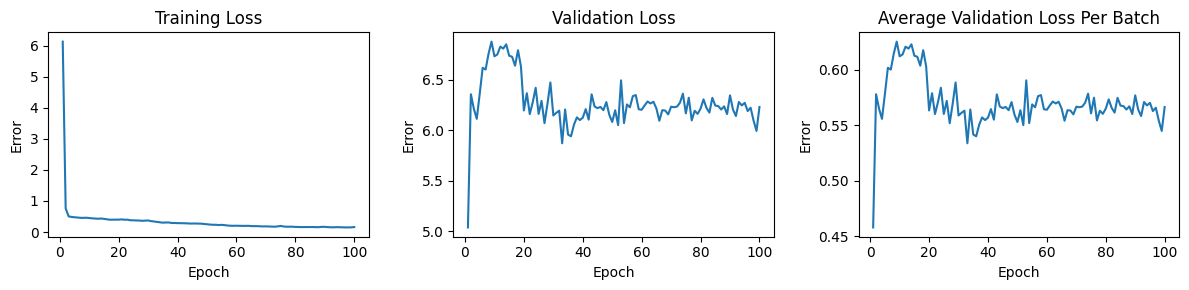

In [63]:
plot_errors(training_loss, valid_loss, avg_valid_loss)

In [64]:
def infer_date_(model, df, scaler, n_future, future_days = None, one_hot_feature = None):

    #Set model training to False
    model.train(False)
    copy_df = dc(df)

    #Case 1: if model predicts multiple days at once
    if n_future > 1:

        #Build Dateframe for future days
        max_date = df['OCCUPANCY_DATE'].max()
        date_range = pd.date_range(start=max_date, end=max_date + pd.Timedelta(days=n_future), freq = 'D')
        df_new = pd.DataFrame({'OCCUPANCY_DATE': date_range})

        #Scaling input Dataframe
        copy_df.set_index('OCCUPANCY_DATE', inplace = True)
        df_scaled = scaler.fit_transform(copy_df)

        if one_hot_feature is not None:
            for i in range(one_hot_feature[1]):

                if i != one_hot_feature[0]:
                    arr = np.zeros((df_scaled.shape[0], 1))
                    df_scaled = np.hstack((arr, df_scaled))
                else:
                    arr = np.ones((df_scaled.shape[0], 1))
                    df_scaled = np.hstack((arr, df_scaled))

        #Convert data to tensor and passing it into the model to get predicted data and converting it into a panda dataframe before returning it
        y = model(torch.tensor(df_scaled).unsqueeze(0).float()).detach().numpy().reshape(-1,1)
        y_ = np.repeat(y, copy_df.shape[1], axis = -1)
        y_actual = scaler.inverse_transform(y_)[:,-1]
        y_inserted = np.insert(y_actual, 0, df['OCCUPIED_PERCENTAGE'].iloc[-1])
        df_new['OCCUPIED_PERCENTAGE'] = pd.DataFrame(y_inserted, columns = ['OCCUPIED_PERCENTAGE'])


    #Case 2: if model predicts one day at a time; therefore need loop to predict all future_days days.
    if n_future == 1 and future_days is not None:

        data = torch.tensor(scaler.fit_transform(np.array(copy_df['OCCUPIED_PERCENTAGE']).reshape(-1, 1)).reshape((-1, copy_df.shape[0], 1))).float()
        for i in range(future_days):
            y = model(data).unsqueeze(0)
            data = torch.cat((data, y), dim = 1)
        data = scaler.inverse_transform(data.squeeze().detach().numpy().reshape(-1, 1)).flatten()

        #Adding a data column to the new data
        max_date = copy_df['OCCUPANCY_DATE'].max()
        date_range = pd.date_range(start=max_date , end=max_date + pd.Timedelta(days=future_days), freq = 'D')
        df_new = pd.DataFrame({'OCCUPANCY_DATE': date_range})

        #Getting the newly generated portion of data
        new_data = data[-future_days:]
        new_data = np.insert(new_data, 0, copy_df['OCCUPIED_PERCENTAGE'].iloc[-1])
        new_data_df = pd.DataFrame(new_data, columns = ['OCCUPIED_PERCENTAGE'])

        #Combined
        df_new['OCCUPIED_PERCENTAGE'] = new_data_df

    return df_new

In [65]:
def plot_general(model, df, n_future, scaler, test_check = False, future_days = None):

  #Deep copying the dataframe
  copy_df = dc(df)

  #If test check, move the data back by n_future days inorder to view model's performance
  if test_check:

    if future_days is None:
      use_date = max(copy_df['OCCUPANCY_DATE']) - pd.Timedelta(days = n_future)
      copy_df = copy_df[copy_df['OCCUPANCY_DATE'] <= use_date]

    elif future_days is not None:
      use_date = max(copy_df['OCCUPANCY_DATE']) - pd.Timedelta(days = future_days)
      copy_df = copy_df[copy_df['OCCUPANCY_DATE'] <= use_date]

  #Getting the inferred data
  data_frame = infer_date_(model, copy_df, scaler,n_future, future_days)

  plt.plot(df['OCCUPANCY_DATE'], df['OCCUPIED_PERCENTAGE'], label='Actual')
  plt.plot(data_frame['OCCUPANCY_DATE'], data_frame['OCCUPIED_PERCENTAGE'], label='Predicted')
  plt.title('All Shelters Occupancy Rates')
  plt.xlabel('Date')
  plt.ylabel('Occupied Percentage (%)')
  plt.legend()
  plt.show()

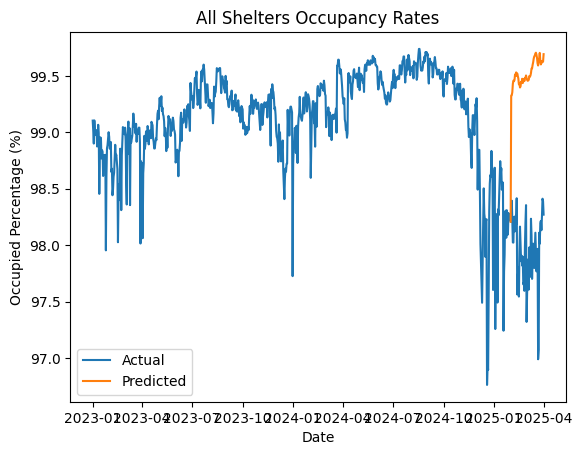

In [ ]:
test_check = True
df = df[used_features]
plot_general(model_one, df, n_future, scaler, test_check)

In [67]:
def plot_random_shelters(model, iso_data, n_future, num_sq, scaler, used_features, test_check = False, future_days = None):

	random_keys = random.sample(list(iso_data), num_sq ** 2)
	fig, axs = plt.subplots(num_sq, num_sq, figsize=(11, 8))
	for i in range(num_sq):
		for j in range(num_sq):

			shelter_index = random_keys[i * num_sq + j]  # Calculate the index from the 1D array

			#Preprocess the iso by copying it into local variables to avoid changing the iso_data itself
			df_use = dc(iso_data[shelter_index])
			max_date = df_use['OCCUPANCY_DATE'].max()

			if df_use['OCCUPANCY_RATE_ROOMS'].isna().all():
				df_use = df_use.rename(columns = {'OCCUPANCY_RATE_BEDS': 'OCCUPIED_PERCENTAGE'})
			else:
				df_use = df_use.rename(columns = {'OCCUPANCY_RATE_ROOMS': 'OCCUPIED_PERCENTAGE'})

			df_infer = df_use[used_features]

			df_infer = feature_check(df_infer)

			#If test check, move the data back by n_future days inorder to view model's performance
			if test_check:

				if future_days is None:
					use_date = max(df_use['OCCUPANCY_DATE']) - pd.Timedelta(days = n_future)
					df_infer = df_infer[df_infer['OCCUPANCY_DATE'] <= use_date]

				elif future_days is not None:
					use_date = max(df_use['OCCUPANCY_DATE']) - pd.Timedelta(days = future_days)
					df_infer = df_infer[df_infer['OCCUPANCY_DATE'] <= use_date]

			try:
				df = infer_date_(model, df_infer, scaler, n_future, future_days)

				axs[i, j].plot(df_use['OCCUPANCY_DATE'], df_use['OCCUPIED_PERCENTAGE'])
				axs[i, j].plot(df['OCCUPANCY_DATE'], df['OCCUPIED_PERCENTAGE'])

				#Labeling
				axs[i, j].set_title(f'Shelter {shelter_index}')
				axs[i, j].set_xlabel('Date')
				axs[i, j].set_ylabel('Occupied Percentage (%)')

			except Exception as e:
				print("Error: " + str(e))

	plt.tight_layout()
	plt.show()

In [68]:
for i in iso_data.copy():
  if iso_data[i].shape[0] <= n_steps - 1:
    del iso_data[i]

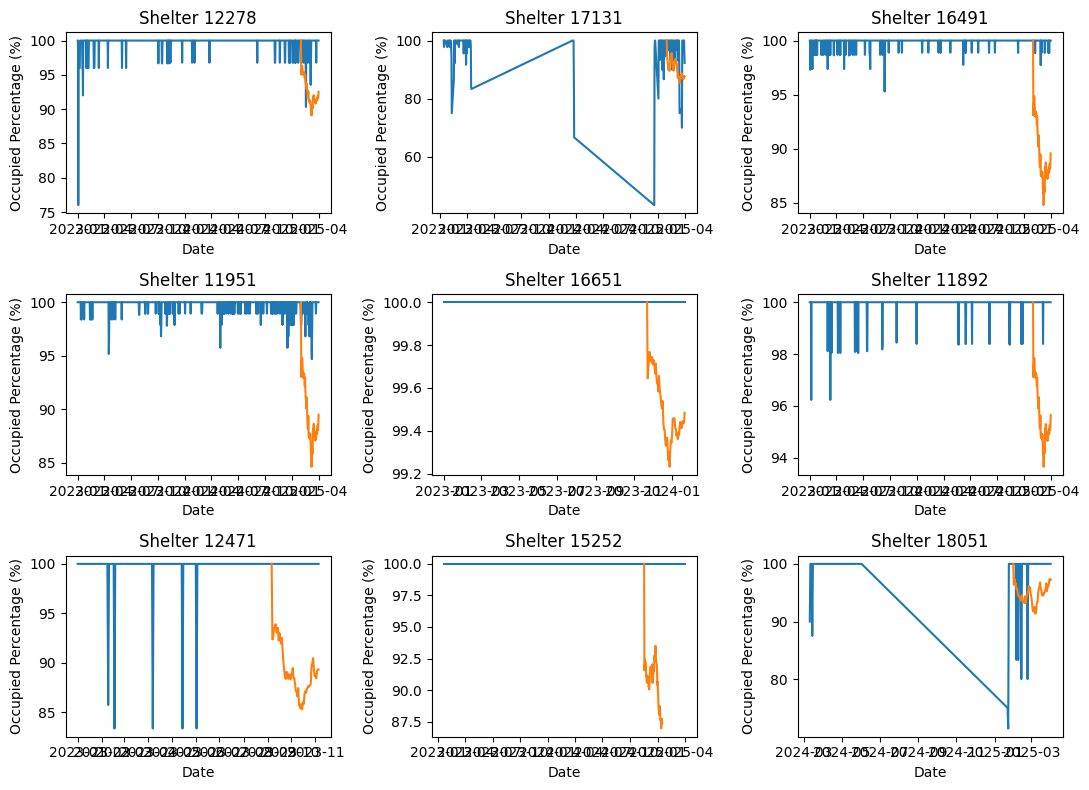

In [69]:
test_check = True
num_sq = 3
plot_random_shelters(model_one, iso_data, n_future, num_sq, scaler, used_features, test_check)

In [70]:
#Reduce iso_data to just the 5 shelters being used for testing
shelters_test = [11794, 11831, 12252, 12254, 12274]
test_data = iso_data.copy()
for i in iso_data.copy():
  if i not in shelters_test:
    del test_data[i]

In [73]:
def multiplying_factor(pred, shel ,adj_factors):
  mult = 1
  for i in adj_factors:
    adj =  (100 + float(adj_factors[i][adj_factors[i][i] == shel[i].iloc[0]]['PERCENT_DIFF'].iloc[0])) / 100
    mult *= adj
  return mult

In [74]:
def calc_loss(model, iso_data, used_features, shel_grouping = None, adj_factors = None):
  #Initialize the Loss variables
  total_shel = 0
  loss_ = 0

  total_shel_ = 0
  loss_sq = 0

  for i in iso_data:

    if len(iso_data[i]) > 60:
      df = iso_data[i]

      #Rename the columns
      if df['OCCUPANCY_RATE_ROOMS'].isna().all():
        df = df.rename(columns = {'OCCUPANCY_RATE_BEDS': 'OCCUPIED_PERCENTAGE'})
      else:
        df = df.rename(columns = {'OCCUPANCY_RATE_ROOMS': 'OCCUPIED_PERCENTAGE'})


      df_mult = df.copy()

      #Selecting on used features
      df = df[used_features]

      df = feature_check(df)

      #Move the dates back by 60 days
      df_use_infer = dc(df)
      use_date = max(df_use_infer['OCCUPANCY_DATE']) - pd.Timedelta(days = 60)
      df_use_infer = df_use_infer[df_use_infer['OCCUPANCY_DATE'] <= use_date]

      #Inferring Data
      if shel_grouping is None:
        df_infer = infer_date_(model, df_use_infer, scaler, n_future, future_days = 60, one_hot_feature = None)
        df_infer_date = min(df_infer['OCCUPANCY_DATE'])
        df_infer = df_infer[df_infer['OCCUPANCY_DATE'] > df_infer_date]
      else:
        df_infer = infer_date_(model, df_use_infer, scaler, n_future, future_days = 60, one_hot_feature = [shel_grouping[i], max(shel_grouping.values()) + 1])
        df_infer_date = min(df_infer['OCCUPANCY_DATE'])
        df_infer = df_infer[df_infer['OCCUPANCY_DATE'] > df_infer_date]

      #Obtain and apply the multiplying factor
      if adj_factors is not None:
        mult = multiplying_factor(df_infer, df_mult, adj_factors)
        df_infer['OCCUPIED_PERCENTAGE'] *= mult

      #data used for loss calculations
      df_loss = dc(df)
      df_loss = df_loss[df_loss['OCCUPANCY_DATE'] > use_date]

      #Calculating Loss
      df_np = df_loss['OCCUPIED_PERCENTAGE'].values
      df_np_infer = df_infer['OCCUPIED_PERCENTAGE'].values

      temp_loss = 0
      temp_loss_sq = 0
      for i in range(len(df_np)):
        temp_loss += abs(df_np[i] - df_np_infer[i])
        temp_loss_sq += abs(df_np[i] - df_np_infer[i]) ** 2
      if temp_loss > 0:
        total_shel += 1
        loss_ += temp_loss
      if temp_loss_sq > 0:
        total_shel_ += 1
        loss_sq += temp_loss_sq
      loss_ /= 60
      loss_sq /= 60
      loss_sq = loss_sq ** (1/2)


  avg_loss = loss_/total_shel
  avg_loss_sq = loss_sq/total_shel_
  return avg_loss, avg_loss_sq

In [ ]:
loss, loss_sq = calc_loss(model_one, test_data.copy(), used_features)

# Mean Absolute Error
print("MAE Loss: " + str(loss))
# Root Mean Squared Error
print("MRSE Loss: " + str(loss_sq))

MAE Loss: 2.2509696449626864
MRSE Loss: 2.3074098599522177


Second Approach

In [77]:
used_features = ['OCCUPANCY_DATE', 'Max Temp (Â°C)', 'Min Temp (Â°C)', 'Total Precip (mm)', 'OCCUPIED_PERCENTAGE']
df_one = dc(df[used_features])
df_one = feature_check(df_one)
print(df_one)

       OCCUPANCY_DATE  Max Temp (Â°C)  Min Temp (Â°C)  Total Precip (mm)  \
0          2023-01-01             5.0             2.7                1.5   
136        2023-01-02             5.6             3.5                0.0   
272        2023-01-03             4.4             2.8                3.3   
408        2023-01-04             4.4             2.5               21.1   
544        2023-01-05             4.8             3.2                0.2   
...               ...             ...             ...                ...   
110030     2025-03-28             3.9             1.4                2.2   
110174     2025-03-29             2.3            -0.1                9.1   
110318     2025-03-30             6.6             0.3                5.2   
110462     2025-03-31            10.9             1.3                0.1   
110605     2025-04-01             4.5            -0.7                0.3   

        OCCUPIED_PERCENTAGE  
0                 99.103995  
136               99.015574

In [81]:
## Defining model running hyperparameters
n_steps = 90
n_future = 60
batch_size = 16
train_test_split = 0.75
scaler = get_scaler()

In [84]:
train_loader_one, test_loader_one = time_series_converter(df_one, scaler, n_steps, n_future, train_test_split, batch_size, used_features)

#Hyperparameters
learning_rate = 1e-3
num_epochs = 100
train_test_split = 0.8
loss_function = nn.MSELoss()
input_size = len(used_features) - 1
hidden_size = 120
num_stacked_layers = 2
output_size = n_future

model_one = LSTM(input_size, hidden_size, num_stacked_layers, output_size)
optimizer = torch.optim.AdamW(model_one.parameters(), lr = learning_rate)

In [85]:
model_one, training_loss, valid_loss, avg_valid_loss = begin_training(model_one, num_epochs, train_loader_one, test_loader_one, loss_function, optimizer)

Epoch: 0
Training Loss: 6.125758960843086
Val Loss: 0.425
***************************************************


Epoch: 5
Training Loss: 0.8324301298707724
Val Loss: 0.321
***************************************************


Epoch: 10
Training Loss: 0.6571386400610209
Val Loss: 0.248
***************************************************


Epoch: 15
Training Loss: 0.6960728093981743
Val Loss: 0.257
***************************************************


Epoch: 20
Training Loss: 0.6109962724149227
Val Loss: 0.195
***************************************************


Epoch: 25
Training Loss: 0.5257630879059434
Val Loss: 0.287
***************************************************


Epoch: 30
Training Loss: 0.5269812745973468
Val Loss: 0.220
***************************************************


Epoch: 35
Training Loss: 0.46069651935249567
Val Loss: 0.218
***************************************************


Epoch: 40
Training Loss: 0.4001869512721896
Val Loss: 0.310
******************************

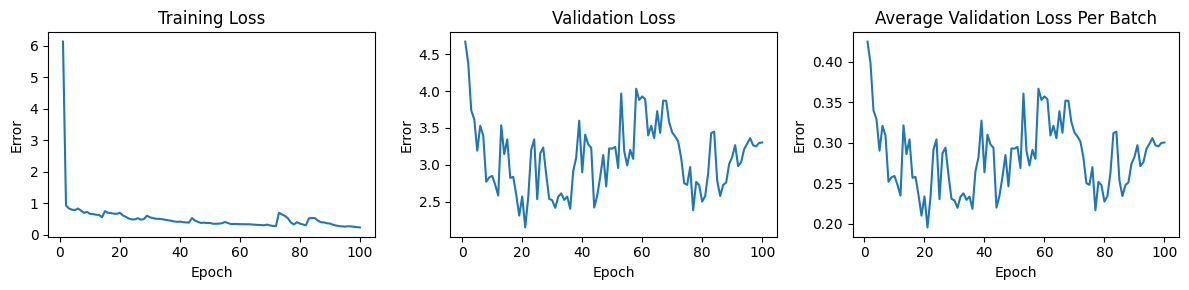

In [86]:
plot_errors(training_loss, valid_loss, avg_valid_loss)

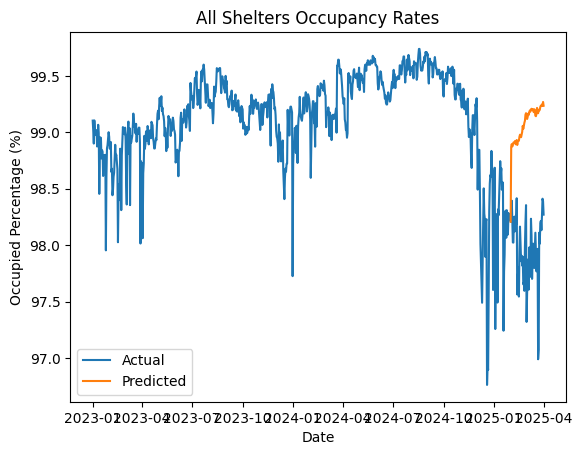

In [87]:
test_check = True
df = df[used_features]
plot_general(model_one, df, n_future, scaler, test_check)

Error: Neither `start` nor `end` can be NaT


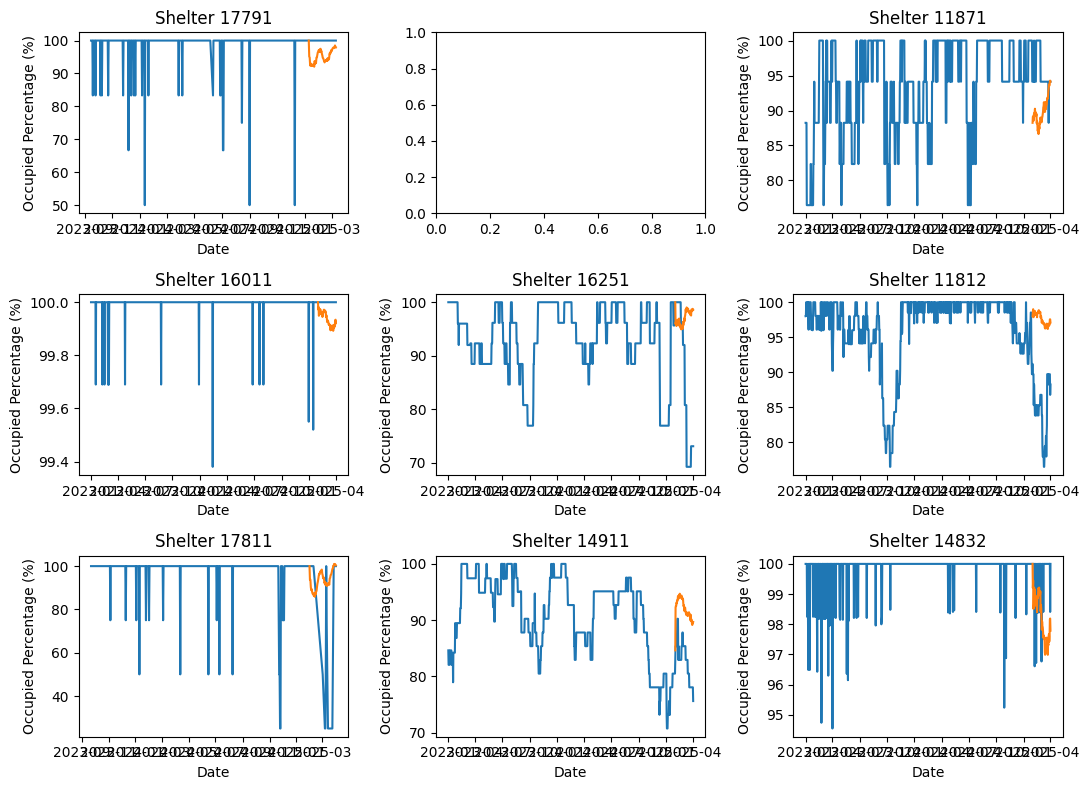

In [88]:
test_check = True
num_sq = 3
plot_random_shelters(model_one, iso_data, n_future, num_sq, scaler, used_features, test_check)

In [89]:
loss, loss_sq = calc_loss(model_one, test_data.copy(), used_features)

# Mean Absolute Error
print("MAE Loss: " + str(loss))
# Root Mean Squared Error
print("MRSE Loss: " + str(loss_sq))

MAE Loss: 0.8663756407845569
MRSE Loss: 1.1120344940344096
